In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [4]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

import math
def log(a: int, b: int) -> float:
    """Logarithm a to the base b
    
    Args:
        a: log int
        b: base int
    """

    return math.log(a, b)

def power(a: int, b: int) -> float:
    """Raise a to the power of b.

    Args:
        a: base int
        b: exponent int
    """
    return a ** b

tools = [add, multiply, divide, log, power]

llm = ChatOpenAI(model="gpt-5")
llm_with_tools = llm.bind_tools(tools)


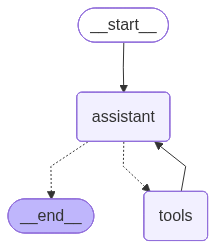

In [5]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [6]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 4 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 4 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_QS5H1vAYjwlLj4SqOwq3I5qD)
 Call ID: call_QS5H1vAYjwlLj4SqOwq3I5qD
  Args:
    a: 4
    b: 3
================================= Tool Message =================================
Name: multiply

12
================================== Ai Message ==================================

12


In [7]:
# Input
initial_input = {"messages": HumanMessage(content="Give power of 2 raised to 16")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()


================================ Human Message =================================

Give power of 2 raised to 16
================================== Ai Message ==================================
Tool Calls:
  power (call_JUgjZNvBjw5yKxoIA7PaUdQi)
 Call ID: call_JUgjZNvBjw5yKxoIA7PaUdQi
  Args:
    a: 2
    b: 16
================================= Tool Message =================================
Name: power

65536
================================== Ai Message ==================================

65536


# Browsing history

In [8]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 4 and 3', additional_kwargs={}, response_metadata={}, id='99e09481-08a1-4736-932c-5010f519aa1a'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 280, 'total_tokens': 370, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CW0i7kelNWsxB5Y6lpgvU14Bx8jAh', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--9af2fc81-d77b-4d56-9f01-2047faece0cc-0', tool_calls=[{'name': 'multiply', 'args': {'a': 4, 'b': 3}, 'id': 'call_QS5H1vAYjwlLj4SqOwq3I5qD', 'type': 'tool_call'}], usage_metadata={'input_tokens': 280, 'output_tokens': 90, 'total_tokens': 370,

In [9]:
all_states = [s for s in graph.get_state_history(thread)]

In [10]:
len(all_states)

5

In [11]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Give power of 2 raised to 16', additional_kwargs={}, response_metadata={}, id='1fbcad49-ce54-4030-a825-8f0917fbaf03')]}, next=('assistant',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0b4cd0-f302-6090-8000-9d3a762939b2'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-29T13:42:06.459296+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0b4cd0-f2ff-614c-bfff-55e759e3725d'}}, tasks=(PregelTask(id='98f544b8-6b71-2cab-a543-61572ba53653', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 218, 'prompt_tokens': 283, 'total_tokens': 501, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 

# Replaying 

In [12]:
to_replay = all_states[-2]

In [13]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Give power of 2 raised to 16', additional_kwargs={}, response_metadata={}, id='1fbcad49-ce54-4030-a825-8f0917fbaf03')]}, next=('assistant',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0b4cd0-f302-6090-8000-9d3a762939b2'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-29T13:42:06.459296+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0b4cd0-f2ff-614c-bfff-55e759e3725d'}}, tasks=(PregelTask(id='98f544b8-6b71-2cab-a543-61572ba53653', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 218, 'prompt_tokens': 283, 'total_tokens': 501, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 

In [14]:
to_replay.values

{'messages': [HumanMessage(content='Give power of 2 raised to 16', additional_kwargs={}, response_metadata={}, id='1fbcad49-ce54-4030-a825-8f0917fbaf03')]}

In [15]:
to_replay.next

('assistant',)

In [16]:
to_replay.config

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b4cd0-f302-6090-8000-9d3a762939b2'}}

In [17]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Give power of 2 raised to 16
================================== Ai Message ==================================
Tool Calls:
  power (call_yd2a6yRMUr8A5gZwV1FDggGo)
 Call ID: call_yd2a6yRMUr8A5gZwV1FDggGo
  Args:
    a: 2
    b: 16
================================= Tool Message =================================
Name: power

65536
================================== Ai Message ==================================

65536


# forking 

In [18]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Give power of 2 raised to 16', additional_kwargs={}, response_metadata={}, id='1fbcad49-ce54-4030-a825-8f0917fbaf03')]

In [19]:
to_fork.config

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b4cd0-f302-6090-8000-9d3a762939b2'}}

In [21]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 4 and 3', 
                               id=to_fork.values["messages"][0].id)]},
)

In [22]:
fork_config

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b4ce0-e5d4-62f0-8001-53779a16113f'}}

In [23]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 4 and 3', additional_kwargs={}, response_metadata={}, id='1fbcad49-ce54-4030-a825-8f0917fbaf03'),
 AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 218, 'prompt_tokens': 283, 'total_tokens': 501, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CW0j8vGec78gfYPO1625tpEeqsNGf', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--452ae694-ad65-4d63-8cde-11d1d4a022d8-0', tool_calls=[{'name': 'power', 'args': {'a': 2, 'b': 16}, 'id': 'call_JUgjZNvBjw5yKxoIA7PaUdQi', 'type': 'tool_call'}], usage_metadata={'input_tokens': 283, 'output_tokens': 218, 'total_tokens': 501, 'input_token_details': {'audio'

In [24]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 4 and 3', additional_kwargs={}, response_metadata={}, id='99e09481-08a1-4736-932c-5010f519aa1a'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 280, 'total_tokens': 370, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CW0i7kelNWsxB5Y6lpgvU14Bx8jAh', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--9af2fc81-d77b-4d56-9f01-2047faece0cc-0', tool_calls=[{'name': 'multiply', 'args': {'a': 4, 'b': 3}, 'id': 'call_QS5H1vAYjwlLj4SqOwq3I5qD', 'type': 'tool_call'}], usage_metadata={'input_tokens': 280, 'output_tokens': 90, 'total_tokens': 370,

In [25]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  power (call_JUgjZNvBjw5yKxoIA7PaUdQi)
 Call ID: call_JUgjZNvBjw5yKxoIA7PaUdQi
  Args:
    a: 2
    b: 16
================================= Tool Message =================================
Name: power

65536
================================== Ai Message ==================================
Tool Calls:
  multiply (call_qkPbV0H0h6yUnebXP91DnStv)
 Call ID: call_qkPbV0H0h6yUnebXP91DnStv
  Args:
    a: 4
    b: 3
================================= Tool Message =================================
Name: multiply

12
================================== Ai Message ==================================

12


In [26]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 4 and 3', additional_kwargs={}, response_metadata={}, id='99e09481-08a1-4736-932c-5010f519aa1a'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 280, 'total_tokens': 370, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CW0i7kelNWsxB5Y6lpgvU14Bx8jAh', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--9af2fc81-d77b-4d56-9f01-2047faece0cc-0', tool_calls=[{'name': 'multiply', 'args': {'a': 4, 'b': 3}, 'id': 'call_QS5H1vAYjwlLj4SqOwq3I5qD', 'type': 'tool_call'}], usage_metadata={'input_tokens': 280, 'output_tokens': 90, 'total_tokens': 370,

# time travel in langgraph api

In [27]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

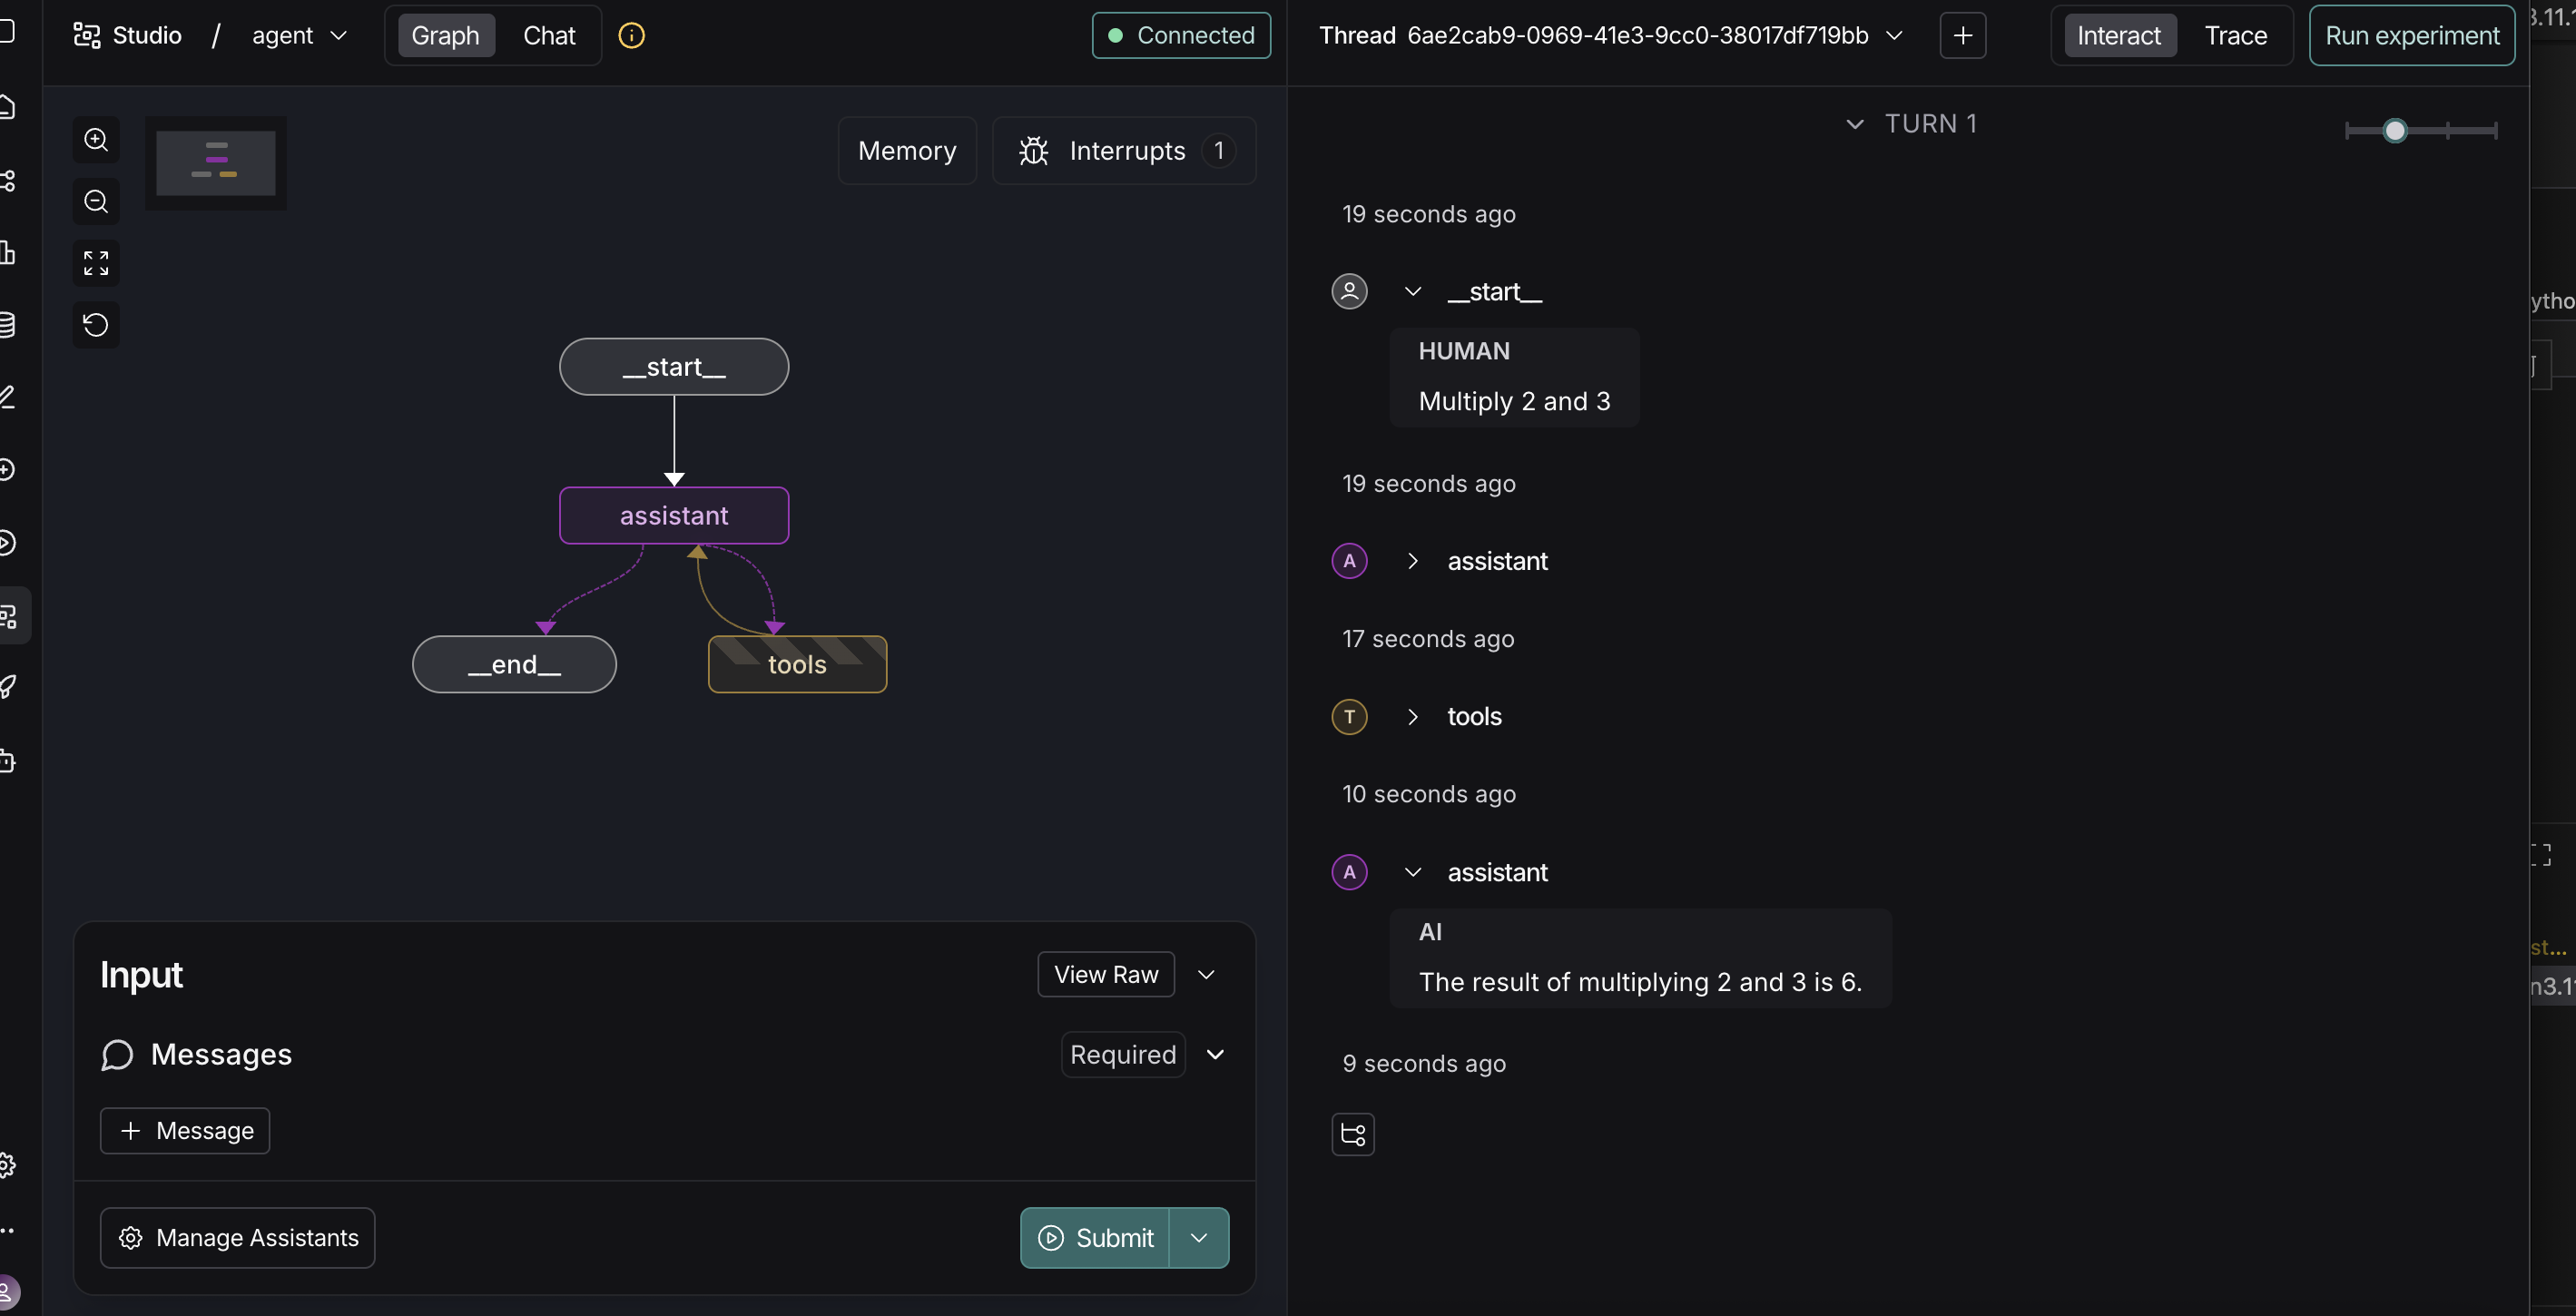

In [28]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CW0w69BqtunGHA6pQCGYeCv1ocFzK', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'lc_run--a8f2552e-4e52-47d5-bf80-e87feda9b57f-0', 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_TMSCQ5QFyG0kk3VWapXFjffG', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 'output_tokens': 17, 'total_tokens': 151, 'input_token_details': {'audio': 0

In [29]:
states = await client.threads.get_history(thread['thread_id'])
to_replay = states[-2]
to_replay

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '54d4b43e-aed9-4711-8fca-0630fa22589d'}]},
 'next': ['assistant'],
 'tasks': [{'id': '0c249aa5-c214-9ce1-be49-4d1f7a642e00',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': {'messages': [{'content': '',
      'additional_kwargs': {'refusal': None},
      'response_metadata': {'token_usage': {'completion_tokens': 17,
        'prompt_tokens': 134,
        'total_tokens': 151,
        'completion_tokens_details': {'accepted_prediction_tokens': 0,
         'audio_tokens': 0,
         'reasoning_tokens': 0,
         'rejected_prediction_tokens': 0},
        'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
       'model_provider': 'openai',
       'model_name': 'gpt-4o-2024-08-06',
       'system_finger

In [30]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay['checkpoint_id']
):      
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '019a3040-f9cd-71b7-a21e-871b2078e43d', 'attempt': 1}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '54d4b43e-aed9-4711-8fca-0630fa22589d'}]}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '54d4b43e-aed9-4711-8fca-0630fa22589d'}, {'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6556

In [31]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CW0x0UqAu4HZztO3g8M5w8dQDHnP1', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'lc_run--52b0fb02-8922-45bd-81fe-7e37c15ac762-0', 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_MTE6T91vXUGePyGhKRrbwqCN', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 'output_tokens': 17, 'total_tokens': 151, 'input_token_details': {'audio': 0

# forking 

In [32]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CW11b6s0tSwYUDC8V7K9PKROjJ3f8', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'lc_run--b9d3418e-366d-40d8-95f9-bee60ef94eb4-0', 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_NTIB6YV66gkPl7ne4IcmJDg8', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 'output_tokens': 17, 'total_tokens': 151, 'input_token_details': {'audio': 0

In [33]:
states = await client.threads.get_history(thread['thread_id'])
to_fork = states[-2]
to_fork['values']

{'messages': [{'content': 'Multiply 2 and 3',
   'additional_kwargs': {},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': '48f4e4c9-b3bf-4e65-b1e7-7ef8c3d2b214'}]}

In [34]:
to_fork['values']['messages'][0]['id']

'48f4e4c9-b3bf-4e65-b1e7-7ef8c3d2b214'

In [35]:
to_fork['next']

['assistant']

In [36]:
to_fork['checkpoint_id']

'1f0b4cfb-92cb-6c78-8000-1ac25dfeab1d'

In [37]:
forked_input = {"messages": HumanMessage(content="Multiply 3 and 3",
                                         id=to_fork['values']['messages'][0]['id'])}

forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)

In [38]:
forked_config

{'checkpoint': {'thread_id': '3d3af949-f18e-4583-8118-8724d0f0d054',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b4cfd-61df-695a-8001-c2d98be8f8bf'},
 'configurable': {'thread_id': '3d3af949-f18e-4583-8118-8724d0f0d054',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b4cfd-61df-695a-8001-c2d98be8f8bf'},
 'checkpoint_id': '1f0b4cfd-61df-695a-8001-c2d98be8f8bf'}

In [39]:
states = await client.threads.get_history(thread['thread_id'])
states[0]

{'values': {'messages': [{'content': 'Multiply 3 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '48f4e4c9-b3bf-4e65-b1e7-7ef8c3d2b214'},
   {'content': '',
    'additional_kwargs': {'refusal': None},
    'response_metadata': {'token_usage': {'completion_tokens': 17,
      'prompt_tokens': 134,
      'total_tokens': 151,
      'completion_tokens_details': {'accepted_prediction_tokens': 0,
       'audio_tokens': 0,
       'reasoning_tokens': 0,
       'rejected_prediction_tokens': 0},
      'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
     'model_provider': 'openai',
     'model_name': 'gpt-4o-2024-08-06',
     'system_fingerprint': 'fp_65564d8ba5',
     'id': 'chatcmpl-CW11b6s0tSwYUDC8V7K9PKROjJ3f8',
     'service_tier': 'default',
     'finish_reason': 'tool_calls',
     'logprobs': None},
    'type': 'ai',
    'name': None,
    'id': 'lc_run--b9d3418e-366d-40d8-95f9-bee60ef94eb4-0',
    'tool_cal

In [40]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Tools Node--------------------
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': 'c0508fc4-25be-4d7d-96e2-394fb2d83b98', 'tool_call_id': 'call_NTIB6YV66gkPl7ne4IcmJDg8', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 'The result of multiplying 3 by 3 is 9.', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 14, 'prompt_tokens': 159, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CW130fWAZTTE9ar1HyWpYFih228P2', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, 'type': 'ai', 'name': None, 'i